# Laboratorio 2

## Integrantes
- Jose Asitimbay
- Brayan Lechon

## Activities
#### 1.  Do a quick EDA that highlights some of the common texts used for each type of review

Librerías Necesarias

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from collections import Counter
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# hide warnings
import warnings
warnings.filterwarnings('ignore')
import string
from tqdm import tqdm

In [3]:
## Descargar recursos de NLTK / ejecutar solo una vez y despues comentar
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

Leer el archivo

In [4]:
df_criticas = pd.read_csv('./data/train.tsv.zip', sep='\t')
df_criticas.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


Primero se ve de manera general la distribucion de los sentimientos en el dataset

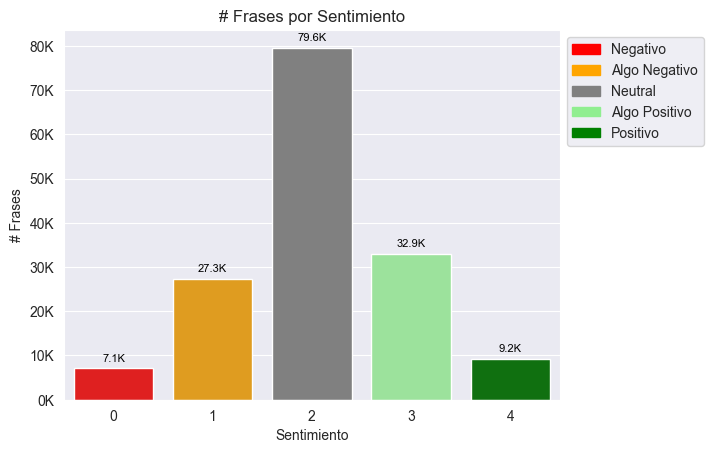

In [34]:
def format_thousands(x, pos):
    return f'{int(x/1000)}K'

# Definir los colores para cada sentimiento
colors = {0: 'red', 1: 'orange', 2: 'gray', 3: 'lightgreen', 4: 'green'}

sentiment_counts = df_criticas['Sentiment'].value_counts().sort_index()

# Crear el gráfico de barras
ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=colors.values())

# Títulos y etiquetas
plt.title('# Frases por Sentimiento')
plt.xlabel('Sentimiento')
plt.ylabel('# Frases')

# Añadir leyenda personalizada
labels = ['Negativo', 'Algo Negativo', 'Neutral', 'Algo Positivo', 'Positivo']
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in colors.keys()]
plt.legend(handles, labels)
sns.move_legend(ax,"upper left",bbox_to_anchor=(1, 1))
# Añadir etiquetas de valores 
for p in ax.patches:
    ax.annotate(f'{p.get_height()/1000:.1f}K', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=8, color='black', xytext=(0, 5), 
                textcoords='offset points')


ax.yaxis.set_major_formatter(FuncFormatter(format_thousands))

# Mostrar gráfico
plt.show()


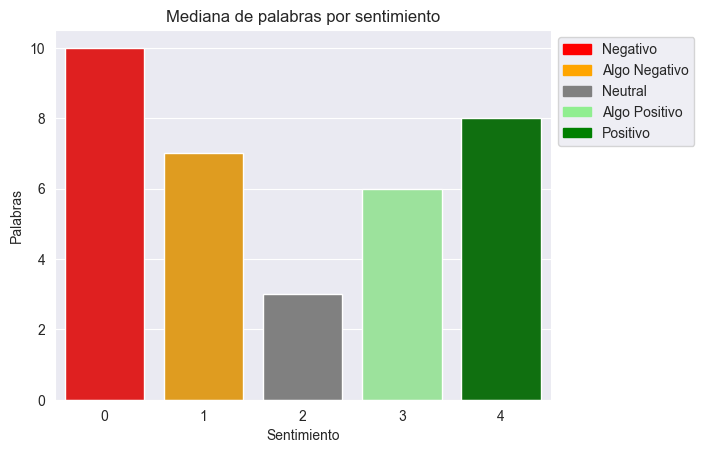

In [30]:

df_criticas['Phrase_length'] = df_criticas['Phrase'].apply(lambda x: len(x.split()))
sentiment_mean_length = df_criticas.groupby('Sentiment')['Phrase_length'].median()

# Create a bar plot
ax = sns.barplot(x=sentiment_mean_length.index, y=sentiment_mean_length.values, palette=colors.values())

# Titles and labels
plt.title('Mediana de palabras por sentimiento')
plt.xlabel('Sentimiento')
plt.ylabel('Palabras')

labels = ['Negativo', 'Algo Negativo', 'Neutral', 'Algo Positivo', 'Positivo']
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in colors.keys()]
# move the legend to an empty part of the plot
plt.legend(handles, labels)
sns.move_legend(ax,"upper left",bbox_to_anchor=(1, 1))


plt.show()


##### WordCloud

Se crea una función que elimina stopwords, hace steaming y lematica cada frase para que el corpus este compuesto unicamente por las palabras que aportan significado.
 
Esto se realiza para que las stopwords no sean las que primero aparecen en nuestro ranking de cada sentimiento 

In [31]:
stop_words = set(stopwords.words('english')) # Definir stopwords
# Instanciar lematizador y stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Función para tokenizar, eliminar puntuación, stopwords, aplicar lematización y stemming
def preprocess_text(text):
    # Eliminar signos de puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenizar y aplicar preprocesamiento
    tokens = [word for word in text.split() if word.lower() not in stop_words]
    tokens_lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    tokens_stemmed = [stemmer.stem(token) for token in tokens_lemmatized]
    
    # Retornar solo si hay tokens restantes después del procesamiento
    return tokens_stemmed if tokens_stemmed else np.nan

Se revisa por cada sentimiento el top 10 de palabras más repetidas, así como un wordcloud.


In [37]:
# funcion para plotear wordcloud y barchart
def plot_wordcloud_and_barchart_clean(data, sentiment_value, title):
    # Filtrar datos por sentimiento
    tokens = data[data['Sentiment'] == sentiment_value]['Text_processed'].sum()
    
    # Contar las palabras más frecuentes
    word_counts = Counter(tokens)
    most_common_words = word_counts.most_common(10)
    
    # Crear WordCloud
    wordcloud = WordCloud(background_color='white').generate(' '.join(tokens))
    
    # Crear subplots
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    # Subplot 1: WordCloud
    axs[0].imshow(wordcloud, interpolation='bilinear')
    axs[0].axis('off')
    axs[0].set_title(f'{title} - WordCloud ')
    
    # Subplot 2: Gráfico de barras de las 10 palabras más comunes
    words, counts = zip(*most_common_words)
    sns.barplot(x=list(counts), y=list(words), ax=axs[1],color='blue')
    axs[1].set_title(f'{title} - Top 10 Words ')
    axs[1].set_xlabel('Frequency')
    
    plt.tight_layout()
    plt.show()

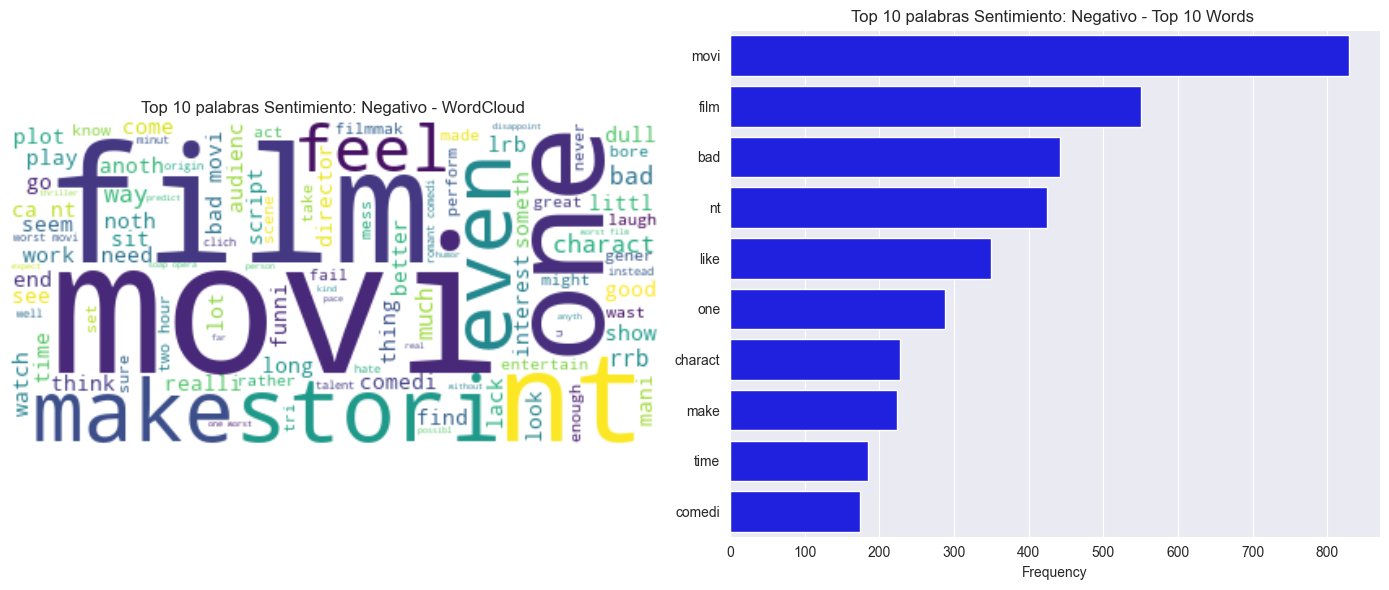

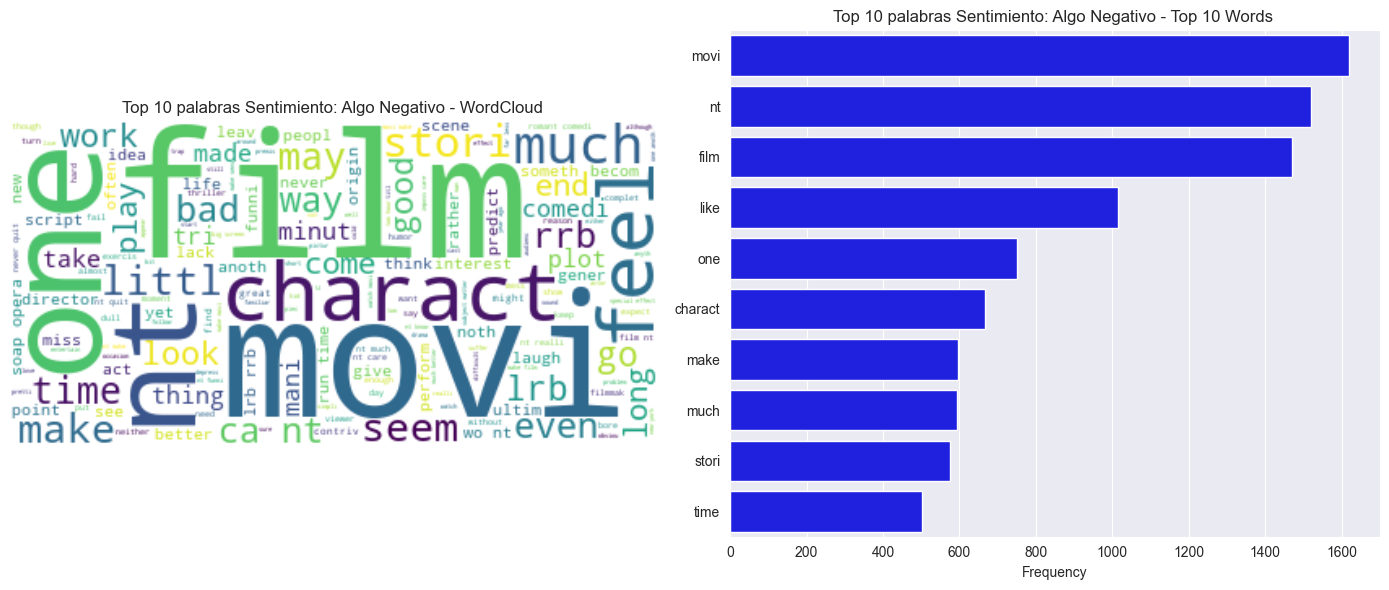

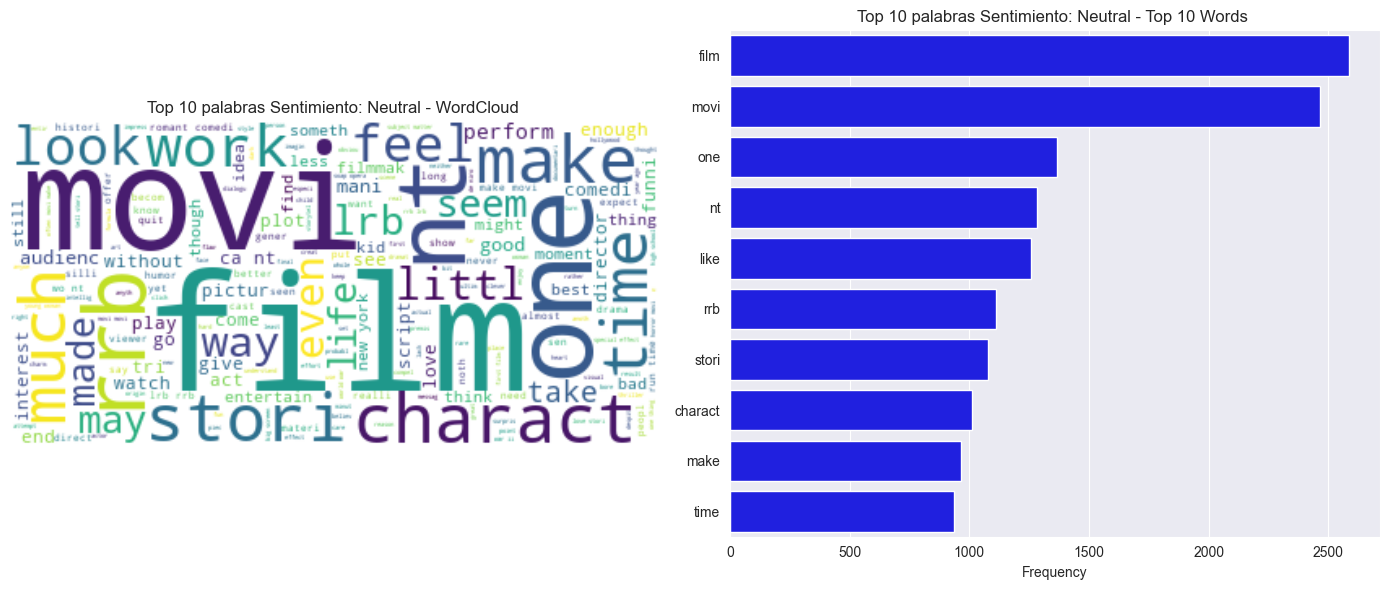

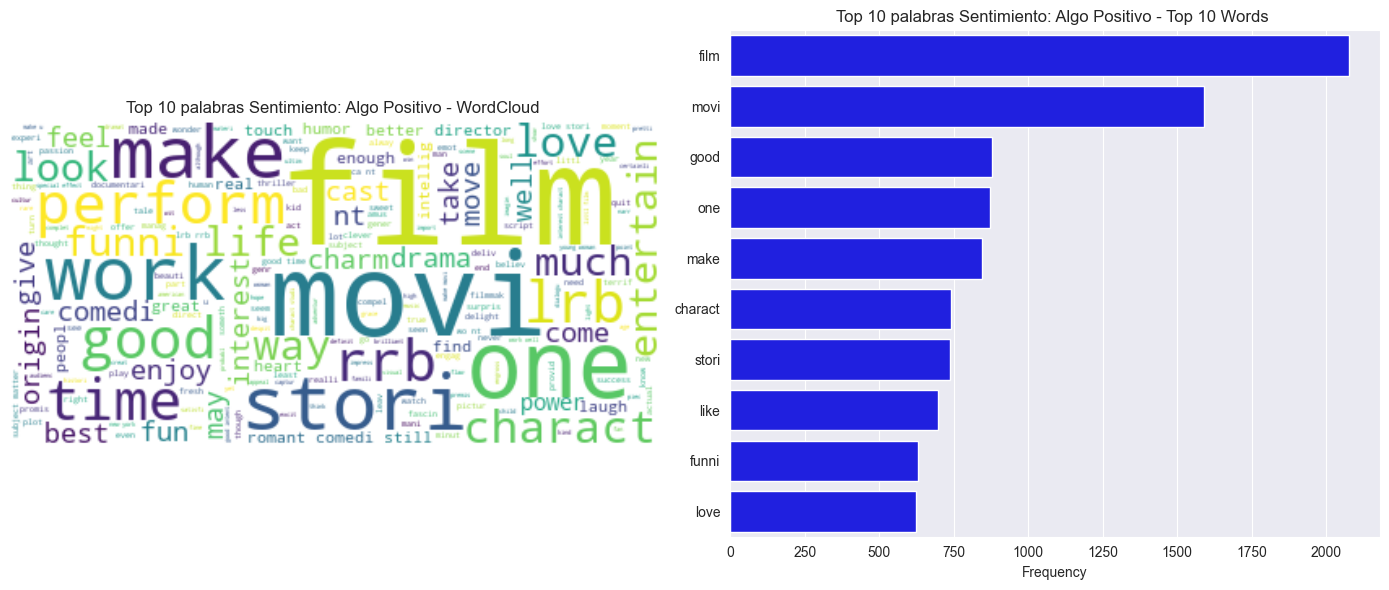

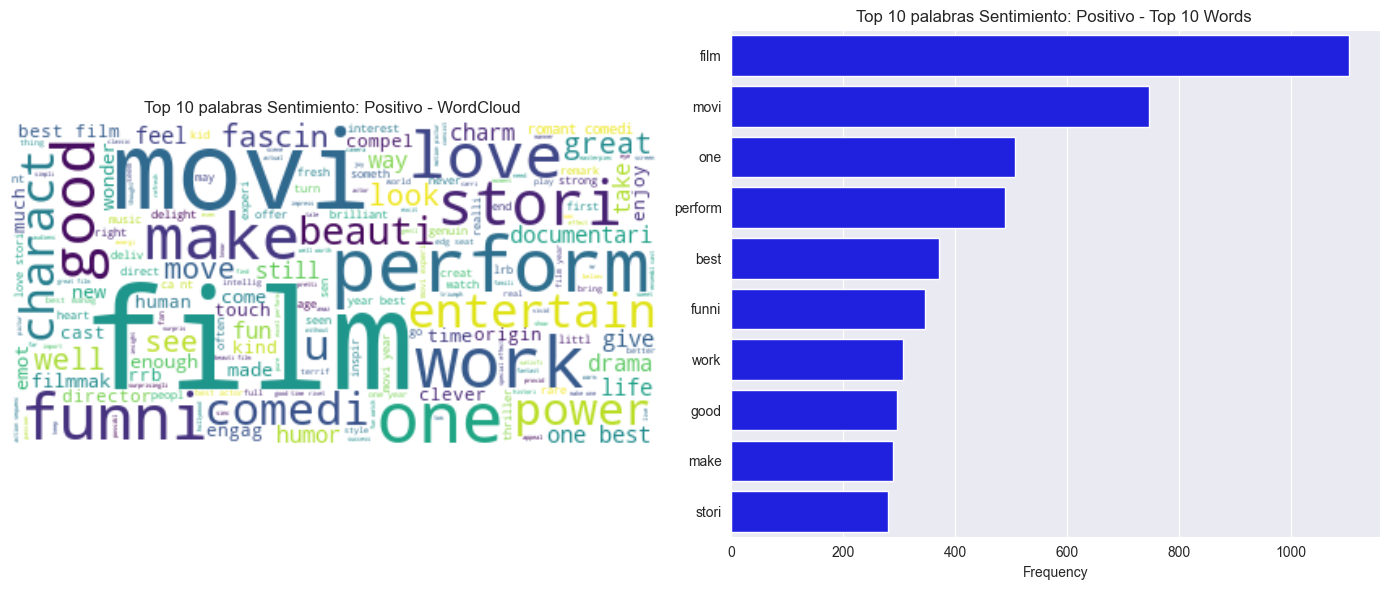

In [38]:
df_criticas_clean = df_criticas.copy(deep=True) # para no modificar el dataframe original
# aplica el procesamiento de texto a cada frase
df_criticas_clean['Text_processed'] = df_criticas_clean['Phrase'].apply(preprocess_text)
df_criticas_clean = df_criticas_clean.dropna(subset=['Text_processed']) 

# Generar gráficos para cada sentimiento con el preprocesamiento aplicado
for i in range(5):
    plot_wordcloud_and_barchart_clean(df_criticas_clean, i, f'Top 10 palabras Sentimiento: {labels[i]}')



Se observa que aparecen palabras caracteristicas de cada sentimiento como good, fun en positivas y bad en negativas. Ademas se puede ver que se tienen palabras en las que se repiten mucho como movie, film, one, etc. Esto debido a la base de datos es de criticas de peliculas.

### Train a Base Model without Preprocessing

Realizamos un modelo base sin preprocesamiento, para ver como se comporta

In [39]:
df_criticas['Text_basic'] = df_criticas['Phrase']

# Usar CountVectorizer para crear el Bag of Words sin ningún preprocesamiento adicional
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_criticas['Text_basic'])

# Asignar la variable objetivo
y = df_criticas['Sentiment']

# Separar en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir y entrenar el modelo Naive Bayes
model = MultinomialNB()
model.fit(X_train, y_train)

# Predecir y evaluar el modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

Accuracy: 0.6118159682173523
              precision    recall  f1-score   support

           0       0.44      0.29      0.35      1416
           1       0.50      0.44      0.47      5527
           2       0.69      0.78      0.73     15639
           3       0.53      0.50      0.51      6707
           4       0.49      0.34      0.40      1923

    accuracy                           0.61     31212
   macro avg       0.53      0.47      0.49     31212
weighted avg       0.60      0.61      0.60     31212



### Preprocessing BoW and Train a Model

Realizamos el mismo proceso pero ahora quitando las stopwords, lematizando y haciendo el stemming

In [44]:
vectorizer = CountVectorizer()
df_criticas_clean['Text_processed'] = df_criticas_clean['Text_processed'].apply(lambda x: ' '.join(x))
X = vectorizer.fit_transform(df_criticas_clean['Text_processed'])

# Asignar la variable objetivo
y = df_criticas_clean['Sentiment']

# Separar en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir y entrenar el modelo Naive Bayes
model = MultinomialNB()
model.fit(X_train, y_train)

# Predecir y evaluar el modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy after preprocessing: {accuracy}')
print(classification_report(y_test, y_pred))

Accuracy after preprocessing: 0.6076754244399974
              precision    recall  f1-score   support

           0       0.46      0.27      0.34      1418
           1       0.49      0.42      0.46      5387
           2       0.68      0.79      0.73     15907
           3       0.51      0.48      0.49      6522
           4       0.46      0.28      0.35      1748

    accuracy                           0.61     30982
   macro avg       0.52      0.45      0.47     30982
weighted avg       0.59      0.61      0.59     30982



Al aplicar el preprocesamiento en el dataset se llega a tener resultados similares en todas las clases.  Esto estaria justificado por que ya que no se toma encuentra la frecuencia de cada palabra en el corpus o el impacto de cada palabra por sentimiento. Además, del desbalanceo que existe entre los todas las clases de sentimientos

A continuacion se va a comparar el dataset antes y despues de aplicar el preprocesamiento

In [50]:
# Calcular estadísticas iniciales sin preprocesamiento
total_phrases_before = df_criticas.shape[0]
total_words_before = df_criticas['Phrase'].apply(lambda x: len(x.split())).sum()

# Número de frases y palabras por sentimiento sin preprocesamiento
phrases_per_sentiment_before = df_criticas.groupby('Sentiment')['Phrase'].count()
words_per_sentiment_before = df_criticas.groupby('Sentiment')['Phrase'].apply(lambda x: x.apply(lambda y: len(y.split())).sum())


# Calcular estadísticas con preprocesamiento
total_phrases_after = df_criticas_clean.shape[0]
total_words_after = df_criticas_clean['Text_processed'].apply(lambda x: len(x.split())).sum()

# Número de frases y palabras por sentimiento con preprocesamiento
phrases_per_sentiment_after = df_criticas_clean.groupby('Sentiment')['Text_processed'].count()
words_per_sentiment_after = df_criticas_clean.groupby('Sentiment')['Text_processed'].apply(lambda x: x.apply(lambda y: len(y.split())).sum())

# Crear un DataFrame para comparar los resultados
comparison_df = pd.DataFrame({
    'Total Phrases': [total_phrases_before, total_phrases_after],
    'Total Words': [total_words_before, total_words_after]
}, index=['Before Preprocessing', 'After Preprocessing'])

comparison_per_sentiment = pd.DataFrame({
    'Phrases': phrases_per_sentiment_before,
    'Words': words_per_sentiment_before,
    'Phrases (Cleaned)': phrases_per_sentiment_after,
    'Words (Cleaned)': words_per_sentiment_after
})

In [53]:
comparison_df.head()


,Total Phrases,Total Words
Before Preprocessing,156060,1124157
After Preprocessing,154906,614503


In [54]:
comparison_per_sentiment.head()

,Phrases,Words,Phrases (Cleaned),Words (Cleaned)
Sentiment,,,,
0,7072,85609,7072,44334
1,27273,248512,27245,132592
2,79582,413398,78518,232261
3,32927,278121,32865,151936
4,9206,98517,9206,53380


Se puede observar que el dataset se reduce en cantidad palabras al aplicar el preprocesamiento. El dataset en cantidad de frases no varia por lo que las frases contienen un minimo de información relevante y no son unidamente palabras vacías.

A pesar de aplicar el preprocesamiento, los resultados no varían significativamente entre los dos modelos, pero la eficiencia del entrenamiento del modelo si ve afectada ya que con una cantidad menor de datos se puede llegar a los resultados similares a nuestro baseline.

### Balancing the Datset by Merging Sentiments

Para reducir la complejidad del modelo y mejorar el desbalance del dataset, lo que se hace es reducir la cantidad de sentimientos. 

Los sentimientos 0 y 1 se fusionan en 'Negative', 2 en 'Neutral' y 3 y 4 en 'Positive'

De esta nos quedamos con 3 clases de sentimientos

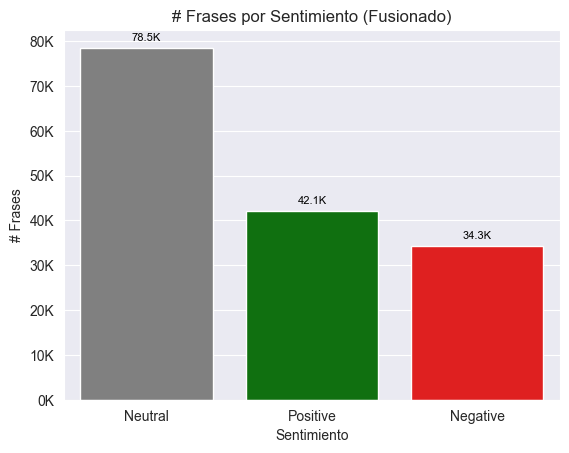

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Fusionar los sentimientos 0 y 1 como 'Negative', 2 como 'Neutral', y 3 y 4 como 'Positive'
df_criticas_clean['Sentiment_Merged'] = df_criticas_clean['Sentiment'].replace({0: 'Negative', 1: 'Negative', 2: 'Neutral', 3: 'Positive', 4: 'Positive'})

# Contar los valores de 'Sentiment_Merged'
sentiment_counts_merged = df_criticas_clean['Sentiment_Merged'].value_counts().reset_index()

# Crear el gráfico de barras con la nueva distribución de sentimientos
colors_merged = {'Negative': 'red', 'Neutral': 'gray', 'Positive': 'green'}
ax = sns.barplot(data=sentiment_counts_merged, x="Sentiment_Merged", y="count", palette=colors_merged)

# Títulos y etiquetas
plt.title('# Frases por Sentimiento (Fusionado)')
plt.xlabel('Sentimiento')
plt.ylabel('# Frases')

# Añadir etiquetas de valores en las barras, con formato de miles (K)
for p in ax.patches:
    ax.annotate(f'{p.get_height()/1000:.1f}K', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=8, color='black', xytext=(0, 5), 
                textcoords='offset points')

# Formatear los ejes Y para mostrar valores en miles (K)
ax.yaxis.set_major_formatter(FuncFormatter(format_thousands))

# Mostrar gráfico
plt.show()


In [62]:
# Usar CountVectorizer para crear el Bag of Words con preprocesamiento aplicado
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_criticas_clean['Text_processed'])

# Asignar la variable objetivo con los sentimientos fusionados
y = df_criticas_clean['Sentiment_Merged']

# Separar en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir y entrenar el modelo Naive Bayes
model = MultinomialNB()
model.fit(X_train, y_train)

# Predecir y evaluar el modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy after preprocessing with merged sentiments: {accuracy}')
print(classification_report(y_test, y_pred))


Accuracy after preprocessing with merged sentiments: 0.6801368536569621
              precision    recall  f1-score   support

    Negative       0.64      0.59      0.62      6805
     Neutral       0.70      0.73      0.72     15907
    Positive       0.66      0.65      0.66      8270

    accuracy                           0.68     30982
   macro avg       0.67      0.66      0.66     30982
weighted avg       0.68      0.68      0.68     30982



Al aplicar una reduccion de categorias se puede ver que el modelo mejora su eficiencia y se obtiene un mejor resultado en la clasificación de los sentimientos, a pesar de esto los resultados aun serian insuficientes.

### Using TF-IDF for Text Vectorization

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string

# Descargar recursos de NLTK si no lo has hecho
nltk.download('stopwords')
nltk.download('wordnet')

# Definir stopwords y preprocesadores
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Función para preprocesar el texto
def preprocess_text(text):
    # Eliminar signos de puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenizar, eliminar stopwords, lematizar y aplicar stemming
    tokens = [word for word in text.split() if word.lower() not in stop_words]
    tokens_lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    tokens_stemmed = [stemmer.stem(token) for token in tokens_lemmatized]
    
    # Unir tokens nuevamente en una cadena de texto
    return ' '.join(tokens_stemmed) if tokens_stemmed else None

# Aplicar el preprocesamiento
df_criticas['Text_processed'] = df_criticas['Phrase'].apply(preprocess_text)

# Eliminar filas con valores nulos resultantes del preprocesamiento
df_criticas = df_criticas.dropna(subset=['Text_processed'])


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Crear una instancia de TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Aplicar TF-IDF al texto preprocesado
X_tfidf = tfidf_vectorizer.fit_transform(df_criticas['Text_processed'])

# Visualizar la forma de la matriz TF-IDF
print("Shape of TF-IDF matrix:", X_tfidf.shape)


In [ ]:


# Asignar la variable objetivo (sentimientos fusionados)
y = df_criticas['Sentiment_Merged']

# Separar en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Definir y entrenar el modelo Naive Bayes
model = MultinomialNB()
model.fit(X_train, y_train)

# Predecir y evaluar el modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy after TF-IDF and classification: {accuracy}')
print(classification_report(y_test, y_pred))


Vemos que no mejora al usar TF IDF podría ser porque Naive Bayes asume que las características (palabras) son condicionalmente independientes dado el sentimiento, y los pesos de TF-IDF podrían no alinear bien con esta suposición.

In [ ]:
# Obtener los nombres de las características (palabras)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Crear una función para obtener las mejores palabras para cada sentimiento
def get_top_tfidf_words_for_sentiment(X_tfidf, data, sentiment_value, sentiment_name, top_n=10):
    # Obtener los índices de las filas que corresponden al sentimiento específico
    sentiment_indices = np.where(data['Sentiment_Merged'] == sentiment_value)[0]
    
    # Extraer las filas correspondientes al sentimiento
    X_sentiment = X_tfidf[sentiment_indices]
    
    # Calcular el promedio de TF-IDF para cada palabra en este sentimiento
    tfidf_means = X_sentiment.mean(axis=0).A1  # Convertir a arreglo unidimensional
    
    # Crear un DataFrame con las palabras y sus puntuaciones TF-IDF
    tfidf_df = pd.DataFrame({'word': feature_names, 'tfidf_score': tfidf_means})
    
    # Ordenar el DataFrame por la puntuación de TF-IDF y seleccionar las top_n palabras
    top_words = tfidf_df.sort_values(by='tfidf_score', ascending=False).head(top_n)
    
    print(f"Top {top_n} words for {sentiment_name} sentiment:")
    print(top_words)
    print("\n")

# Obtener las 10 mejores palabras por cada sentimiento
get_top_tfidf_words_for_sentiment(X_tfidf, df_criticas, 'Negative', 'Negative')
get_top_tfidf_words_for_sentiment(X_tfidf, df_criticas, 'Neutral', 'Neutral')
get_top_tfidf_words_for_sentiment(X_tfidf, df_criticas, 'Positive', 'Positive')
